# Import Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import List
from typing import Tuple
import time # 計算時間差
import concurrent.futures # for opencv paralle_for_

# Define some utilize function

In [3]:
'''
 single level optical flow
 return keypoint2: List[cv2.KeyPoint], success: List[bool]
'''
def OpticalFlowSingleLevel(
        img1: np.ndarray,
        img2: np.ndarray,
        kp1: List[cv2.KeyPoint],
        inverse: bool = False,
        has_initial_guess: bool = False)->Tuple[List[cv2.KeyPoint], List[bool]]:
    kp2 = []
    for i in range(len(kp1)):
        kp = cv2.KeyPoint(0, 0, 0)
        kp2.append(kp)
    success = []
    for i in range(len(kp1)):
        success.append(False)
    
    tracker = OpticalFlowTracker(img1, img2, kp1, kp2, success, inverse, has_initial_guess)

    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #   # executor.map(tracker.calculateOpticalFlow, range(len(kp1))
    #   futures = [executor.submit(tracker.calculate_optical_flow, i) for i in range(len(kp1))]
    #   results = [future.result() for future in concurrent.futures.as_completed(futures)]
    myRange = [0, len(keypoint1)]
    tracker.calculateOpticalFlow(myRange)
    kp2 = tracker.get_keypoint2()
    success = tracker.get_success()
        
    return kp2, success

In [15]:
import time
milliseconds = int(time.time() * 1000)

print("当前时间的毫秒数：", milliseconds)

当前时间的毫秒数： 1694011867776


In [16]:
'''
 multi level optical flow, scale of pyramid is set to 2 by default
 the image pyramid will be create inside the function
 return kp1, kp2, success
'''
def OpticalFlowMultiLevel(
    img1: np.ndarray,
    img2: np.ndarray,
    kp1: List[cv2.KeyPoint],
    kp2: List[cv2.KeyPoint],
    success: List[bool],
    inverse: bool=False,)->Tuple[List[cv2.KeyPoint], List[bool]]:
    print('OpticalFlowMultiLevel')
    # parameters
    pyramids = 4
    pyramid_scale = 0.5
    scales = [1.0, 0.5, 0.25, 0.125]
    # create pyramids
    t1 = time.perf_counter()
    pyr1 = []
    pyr2 = []
    for i in range(pyramids):
      if i==0:
        pyr1.append(img1)
        pyr2.append(img2)
      else:
        new_width = int(pyr1[i - 1].shape[1] * pyramid_scale)
        new_height = int(pyr1[i - 1].shape[0] * pyramid_scale)
        img1_pyr = cv2.resize(pyr1[i-1], (new_width, new_height))
        new_width = int(pyr2[i - 1].shape[1] * pyramid_scale)
        new_height = int(pyr2[i - 1].shape[0] * pyramid_scale)
        img2_pyr = cv2.resize(pyr2[i-1], (new_width, new_height))
        pyr1.append(img1_pyr)
        pyr2.append(img2_pyr)
    t2 = time.perf_counter()
    time_used = t2-t1
    print('build pyramid time: ', time_used)
    # coarse-to-fine LK tracking in pyramids
    kp1_pyr = []
    kp2_pyr = []
    for kp in kp1:
      kp_top = cv2.KeyPoint(kp.pt[0]*scales[pyramids-1], kp.pt[1]*scales[pyramids-1], kp.size)
      kp1_pyr.append(kp_top)
      kp2_pyr.append(kp_top)

    for level in range(pyramids-1, -1, -1):
      success = []
      t1 = time.perf_counter()
      kp2_pyr, success = OpticalFlowSingleLevel(pyr1[level], pyr2[level], kp1_pyr, inverse, True)
      t2 = time.perf_counter()
      time_used = t2-t1
      print('track pyr %d cost time %f'%(level, time_used))
      if level > 0:
        for i in range(len(kp1_pyr)):
          kp_x = kp1_pyr[i].pt[0] / pyramid_scale
          kp_y = kp1_pyr[i].pt[1] / pyramid_scale
          kp_size = kp1_pyr[i].size
          new_kp = cv2.KeyPoint(kp_x, kp_y, kp_size)
          kp1_pyr[i] = new_kp
        
        for i in range(len(kp2_pyr)):
          kp_x = kp2_pyr[i].pt[0] / pyramid_scale
          kp_y = kp2_pyr[i].pt[1] / pyramid_scale
          kp_size = kp2_pyr[i].size
          new_kp = cv2.KeyPoint(kp_x, kp_y, kp_size)
          kp2_pyr[i] = new_kp

    kp2 = []
    for kp in kp2_pyr:
      kp2.append(kp)
        
    return kp2, success

# Define Optical Flow Tracker Class

In [18]:
# both tuple and list can do this
myTuple = [1,2]
a,b= myTuple
print('a: %d, b: %d'%(a,b))

a: 1, b: 2


# Load Image

In [19]:
import os
if os.path.exists('./LK1.png'):
  image1_path = './LK1.png'
  image2_path = './LK2.png'
else:
  print('No file exist')

In [20]:
# images, note they are CV_8UC1, not CV_8UC3
img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

In [21]:
# Check Files in Current Directory
current_path = os.getcwd()
file_list = os.listdir(current_path)

# Detect Keypoint

In [31]:
# GetPixelValue(img1, 0, 0)
# Q: why not just img1[0][0]?
# A: 用雙線性插值法取值
def GetPixelValue(image: np.ndarray, x: float, y: float)->float:    
    # boundary check
    yLimit, xLimit = image.shape
    if x<0:
        x=0
    if y<0:
        y=0
    if x>(xLimit-1):
        x = xLimit-2
    if y>(yLimit-1):
        y = yLimit-2
    xx = x-np.floor(x)
    yy = y-np.floor(y)
    x_a1 = np.min([xLimit - 1, int(x) + 1])
    y_a1 = np.min([yLimit - 1, int(y) + 1])
    x = int(x)
    y = int(y)
    x_a1 = int(x_a1)
    y_a1 = int(y_a1)
    xx = int(xx)
    yy = int(yy)
    
    return (1 - xx) * (1 - yy) * image[y][x] + xx * (1 - yy) * image[y][x_a1] + (1 - xx) * yy * image[y_a1][x] + xx * yy * image[y_a1][x_a1]

from typing import List

class OpticalFlowTracker:
    def __init__(self,
                 img1: np.ndarray,
                 img2: np.ndarray,
                 kp1: List[cv2.KeyPoint],
                 kp2: List[cv2.KeyPoint],
                 success: List[bool],
                 inverse: bool=True,
                 hasInit: bool=False)->None:
        self.img1 = img1
        self.img2 = img2
        self.kp1 = kp1
        self.kp2 = kp2
        self.success = success
        self.inverse = inverse
        self.hasInit = hasInit
        print('hello')
    
    def calculateOpticalFlow(self, myRange:List[int]):
        # print('calculate optical flow')
        half_patch_size = 4
        iterations = 10
        start, end = myRange
        for i in range(start, end):
          kp = self.kp1[i]
          dx = 0
          dy = 0
          if self.hasInit:
            dx = self.kp2[i].pt[0]-kp.pt[0]
            dy = self.kp2[i].pt[1]-kp.pt[1]
    
          cost = 0
          lastCost = 0
          success = True # indicate if this point succeeded
          H = np.zeros((2, 2)) # Hessian
          b = np.zeros(2)     # bias
          J = np.zeros(2)
    
          for j in range(iterations):
            if not self.inverse:
              H = np.zeros((2, 2)) # Hessian
              b = np.zeros(2)     # bias
            else:
              # Only reset b
              b = np.zeros(2)
    
            cost = 0
    
            # compute cost and Jacobian
            for x in range(-half_patch_size, half_patch_size):
              for y in range(-half_patch_size, half_patch_size):
                error = GetPixelValue(img1, kp.pt[0] + x, kp.pt[1] + y) - GetPixelValue(img2, kp.pt[0] + x + dx, kp.pt[1] + y + dy) # Jacobian
                if not self.inverse:
                  J = -1.0 * np.array([
                      0.5 * (GetPixelValue(img2, kp.pt[0] + dx + x + 1, kp.pt[1] + dy + y) - GetPixelValue(img2, kp.pt[0] + dx + x - 1, kp.pt[1] + dy + y)),
                      0.5 * (GetPixelValue(img2, kp.pt[0] + dx + x, kp.pt[1] + dy + y + 1) - GetPixelValue(img2, kp.pt[0] + dx + x, kp.pt[1] + dy + y - 1))
                      ])
                elif iter==0:
                  # in inverse mode, J keeps same for all iterations
                  # NOTE this J does not change when dx, dy is updated, so we can store it and only compute error
                  J = -1.0 * np.array([
                      0.5 * (GetPixelValue(img1, kp.pt[0] + x + 1, kp.pt[1] + y) - GetPixelValue(img1, kp.pt[0] + x - 1, kp.pt[1] + y)),
                      0.5 * (GetPixelValue(img1, kp.pt[0] + x, kp.pt[1] + y + 1) - GetPixelValue(img1, kp.pt[0] + x, kp.pt[1] + y - 1))
                      ])
                # compute H, b and set cost;
                b += -error * J;
                cost += error * error;
                if (self.inverse == False or iter == 0):
                  # Update H
                  H += J * J.transpose()
            # Compute update
            update = np.linalg.solve(H, b)
    
            if update is None:
              print('update is none. Fail')
              break
            if iter>0 and cost > lastCost:
              break
    
            # update dx, dy
            dx += update[0]
            dy += update[1]
            lastCost = cost
            succ = True
    
            if update.norm() < 1e-2:
              # converge
              break
        success[i] = succ
        # set kp2
        self.kp2[i].pt = kp.pt + cv2.Point2f(dx, dy)
    
    def get_keyPoint2(self):
        return self.kp2
    
    def get_success(self):
        return self.success
    
gftt = cv2.GFTTDetector_create()
keypoint1 = gftt.detect(img1, None)
# keypoint2 = gftt.detect(img2, None)
kp2_single = []
success_single = []
kp2_single, success_single = OpticalFlowSingleLevel(img1, img2, keypoint1)
# then test multi-level LK
kp2_multi = []
success_multi = []
t1 = time.perf_counter()
kp2_multi, success_multi = OpticalFlowMultiLevel(img1, img2, keypoint1, kp2_multi, success_multi, True);
t2 = time.perf_counter()
time_used = t2-t1
print('optical flow by gaussian-newton: ', time_used)


hello


KeyboardInterrupt: 

# plot the differences of Single-Layer-Optical-Flow, Multi-Layer-Optical-Flow and OpticalFlow of Opencv

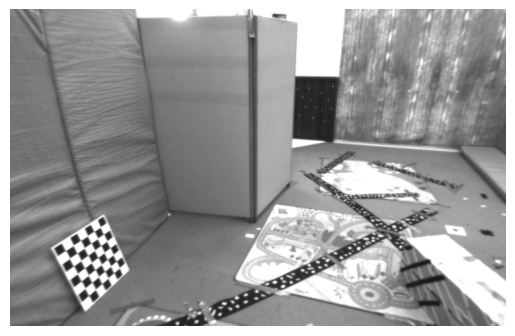

In [30]:
img2_single = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
for i in range(0, len(kp2_single)):
    if success_single[i]:
        radius = 50
        color = (0, 255, 0)  # Green
        thickness = 2
        cv2.circle(img2_single, kp2_single[i].pt, radius, color, thickness)
        cv2.line(img2_single, keypoint1[i].pt, kp2_single[i].pt, color)
%matplotlib inline
plt.imshow(img2_single)
plt.axis('off')
plt.show()

In [33]:
# len(keypoint1)
kp2 = []
kp2=kp2[:len(keypoint1)]
len(kp2)

0

In [ ]:

'''
    // use opencv's flow for validation
    vector<Point2f> pt1, pt2;
    for (auto &kp: kp1) pt1.push_back(kp.pt);
    vector<uchar> status;
    vector<float> error;
    t1 = chrono::steady_clock::now();
    cv::calcOpticalFlowPyrLK(img1, img2, pt1, pt2, status, error);
    t2 = chrono::steady_clock::now();
    time_used = chrono::duration_cast<chrono::duration<double>>(t2 - t1);
    cout << "optical flow by opencv: " << time_used.count() << endl;

    // plot the differences of those functions
    Mat img2_single;
    cv::cvtColor(img2, img2_single, CV_GRAY2BGR);
    for (int i = 0; i < kp2_single.size(); i++) {
        if (success_single[i]) {
            cv::circle(img2_single, kp2_single[i].pt, 2, cv::Scalar(0, 250, 0), 2);
            cv::line(img2_single, kp1[i].pt, kp2_single[i].pt, cv::Scalar(0, 250, 0));
        }
    }

    Mat img2_multi;
    cv::cvtColor(img2, img2_multi, CV_GRAY2BGR);
    for (int i = 0; i < kp2_multi.size(); i++) {
        if (success_multi[i]) {
            cv::circle(img2_multi, kp2_multi[i].pt, 2, cv::Scalar(0, 250, 0), 2);
            cv::line(img2_multi, kp1[i].pt, kp2_multi[i].pt, cv::Scalar(0, 250, 0));
        }
    }

    Mat img2_CV;
    cv::cvtColor(img2, img2_CV, CV_GRAY2BGR);
    for (int i = 0; i < pt2.size(); i++) {
        if (status[i]) {
            cv::circle(img2_CV, pt2[i], 2, cv::Scalar(0, 250, 0), 2);
            cv::line(img2_CV, pt1[i], pt2[i], cv::Scalar(0, 250, 0));
        }
    }

    cv::imshow("tracked single level", img2_single);
    cv::imshow("tracked multi level", img2_multi);
    cv::imshow("tracked by opencv", img2_CV);
    cv::waitKey(0);

    return 0;
}'''

array([1., 1.])

In [58]:
kp = cv2.KeyPoint(1,1,1)
kp.size

1.0